In [1]:
import os
import sys
import pathlib

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rnd
import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from rationality import dynamics as dyn, objectives as obj, distributions as dst,\
    controllers as ctl, simulate as sim, geometry as geom, util

from mpl_toolkits.axes_grid1 import make_axes_locatable

from typing import Optional

In [3]:
pathlib.Path('figures/').mkdir(parents=True, exist_ok=True)

plt.style.reload_library()
plt.style.use(['notebook'])

#plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'


%config InlineBackend.figure_format = 'svg'

save_figures = False
figure_formats = {'png', 'pdf'}

In [4]:
width = 1.0
height = 1.0

obs_width = 0.05

middle_height = 0.4
middle_offset = 0.17
edge_height = 0.1

ic = jnp.array([0.15, 0.4])

prior_params = dst.GaussianParams(jnp.zeros(2), 0.0008 * jnp.eye(2))
ol_dist = dst.gaussian(*prior_params)
trials = 1000
batch_size = 10000
horizon = 100

trajectories_to_draw = 5

grid_spacing = 0.05
goal_centroid = jnp.array([(0.5 + obs_width / 2) + 3 * (0.5 - obs_width / 2) / 4, 0.1])

In [5]:
obstacles = [geom.aabb(jnp.array([0.5, edge_height / 2]), jnp.array([obs_width, edge_height])),
             geom.aabb(jnp.array([0.5, 0.5 - middle_offset]), jnp.array([obs_width, middle_height])),
             geom.aabb(jnp.array([0.5, 1 - edge_height / 2]), jnp.array([obs_width, edge_height]))]

workspace = geom.workspace(width, height, obstacles)

gap1_height = 0.5 - edge_height - middle_height / 2 - middle_offset
gap2_height = 0.5 - edge_height - middle_height / 2 + middle_offset

gaps = [geom.aabb(jnp.array([0.5, edge_height + gap1_height / 2]), jnp.array([obs_width, gap1_height])),
        geom.aabb(jnp.array([0.5, 1 - edge_height - gap2_height / 2]),
                                    jnp.array([obs_width, gap2_height])),]

goal = geom.aabb(goal_centroid, jnp.array([(0.5 - obs_width / 2) / 2, 0.2]))

In [6]:
def draw_workspace(workspace: geom.Workspace, ic: Optional[jnp.ndarray],
                   goal: Optional[geom.Polytope], ax: Optional[plt.Axes] = None) -> plt.Axes:
    width, height = workspace.boundary.dimensions
    obstacles = workspace.obstacles

    if ax is None:
        ax = plt.gca()

    ax.set_xlim([0, width])
    ax.set_ylim([0, height])

    if ic is not None:
        ax.scatter(ic[0], ic[1], marker='x', color='k', s=180)

    for i in range(obstacles.centroid.shape[0]):
        geom.draw(geom.aabb(obstacles.centroid[i, :], obstacles.dimensions[i, :]), ax)

    # for g in gaps:
    #     g.draw(ax, hatch='.')

    if goal is not None:
       geom.draw(goal, ax, hatch='/')

    return ax

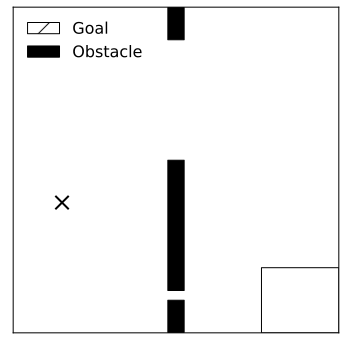

In [7]:
plt.figure()
draw_workspace(workspace, ic, goal)

goal_patch = patches.Patch(fill=False, edgecolor='k', hatch=r'/', label='Goal')
obs_patch = patches.Patch(fill=True, color='k', label='Obstacle')
plt.gca().legend(handles=[goal_patch, obs_patch], loc=2, frameon=False)

plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_aspect('equal')

util.savefig('figures/workspace', figure_formats, perform_save=save_figures)

In [8]:
A = jnp.array([[1.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 1.0],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

B = jnp.array([[0.0, 0.0],
               [0.0, 0.0],
               [1.0, 0.0],               
               [0.0, 1.0]])

               

Q = jnp.zeros((4, 4))
R = jnp.eye(2)
Qf = jnp.diag(jnp.array([1.0, 1.0, 0.0, 0.0]))

dynamics = dyn.linear(A, B)
objective = obj.quadratic(Q, R, Qf, goal_centroid)

@jax.jit
def stopping_condition(state, input, t, next_state):
    return ~(geom.freespace_contains_point(workspace, state[:2]) &
             geom.freespace_contains_point(workspace, state[:2]) &
             geom.freespace_contains_segment(workspace, state[:2], next_state[:2]))

In [9]:
controller = ctl.motion.create()

DeviceArray(True, dtype=bool)